# Context and Goal of This Analysis

Before diving into the data, we clarify the purpose of this notebook.

This analysis focuses on understanding the structure, quality, and risk patterns of the Lending Club loan dataset, considering only information available at the time of loan application.

The goal is not to train models yet, but to:
- understand the dataset composition,
- validate assumptions,
- identify potential issues (e.g. imbalance, leakage, data quality),
- and generate hypotheses to guide feature engineering, modeling and decision making.

# Dataset Overview

We start with a high-level inspection of the dataset to answer the following questions:

- How many observations and variables are available?
- What are the data types of each variable?
- Is the dataset size compatible with the intended modeling approach?


In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

sns.set_theme()

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_parquet('../data/lending_club.parquet')

print(data.shape)
data.head()

(2925492, 141)


,loan_id,loan_amount_requested,loan_amount_funded,loan_amount_funded_investors,loan_term_months,interest_rate,monthly_payment,loan_grade,loan_subgrade,employment_title,employment_length_years,home_ownership_status,annual_income,income_verification_status,loan_issue_date,loan_status,payment_plan_flag,loan_listing_url,loan_purpose,loan_title,zip_code_first3,state,debt_to_income_ratio,delinquencies_past_2years,earliest_credit_line_date,fico_score_low,fico_score_high,inquiries_last_6months,months_since_last_delinquency,months_since_last_public_record,open_credit_lines,public_records_count,revolving_balance,revolving_utilization_rate,total_credit_lines,initial_listing_status,outstanding_principal,outstanding_principal_investors,total_payments_received,total_payments_received_investors,total_principal_received,total_interest_received,total_late_fees_received,recoveries_post_chargeoff,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,fico_score_high_last,fico_score_low_last,collections_12months_excluding_medical,months_since_major_derogatory,policy_code,application_type,annual_income_joint,debt_to_income_ratio_joint,verification_status_joint,accounts_currently_delinquent,total_collection_amount,total_current_balance,open_trades_last_6months,active_installment_trades,installment_accounts_opened_12m,installment_accounts_opened_24m,months_since_recent_installment,total_installment_balance,installment_utilization,revolving_trades_opened_12m,revolving_trades_opened_24m,max_balance_bankcard,all_util,total_rev_hi_lim,finance_inquiries,finance_trades_count,inquiries_last_12months,accounts_opened_past_24months,average_current_balance,bankcard_open_to_buy,bankcard_utilization,chargeoffs_within_12months,delinquent_amount,months_since_oldest_installment,months_since_oldest_revolving,months_since_recent_revolving,months_since_recent_account,mortgage_accounts_count,months_since_recent_bankcard,months_since_recent_bankcard_delinquency,months_since_recent_inquiry,months_since_recent_revolving_delinquency,accounts_ever_120days_past_due,active_bankcard_accounts,active_revolving_trades,satisfactory_bankcard_accounts,bankcard_accounts_count,installment_accounts_count,open_revolving_trades,revolving_accounts_count,revolving_trades_with_balance,satisfactory_accounts_count,accounts_120days_past_due,accounts_30days_past_due,accounts_90plus_days_past_due_24m,accounts_opened_past_12months,percent_trades_never_delinquent,percent_bankcard_over_75pct_limit,public_records_bankruptcies,tax_liens_count,total_high_credit_limit,total_balance_excluding_mortgage,total_bankcard_limit,total_installment_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,secondary_app_earliest_credit_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,secondary_app_active_installment_trades,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_plan_flag,hardship_plan_type,hardship_plan_reason,hardship_plan_status,hardship_deferral_months,hardship_plan_monthly_payment,hardship_plan_start_date,hardship_plan_end_date,hardship_payment_plan_start_date,hardship_plan_length_months,hardship_plan_days_past_due,hardship_plan_loan_status,hardship_projected_interest,hardship_payoff_balance,hardship_last_payment_amount,debt_settlement_flag
0,1077501,5000.0,5000.0,4975.0,36,0.1065,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,0.837,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,2015-01-01,171.62,NaT,2020-05-01,704.0,700.0,0.0,NaN,1.0,Individual,NaN,NaN,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N

# Target Eligibility and Censoring

Before assessing data quality or risk patterns, we define which loans are eligible to be included in the analysis.

As this project focuses on a granting model, the target must represent a final contract-level outcome: whether the loan was fully repaid or not within a defined observation window. We won't consider strategies related to collections, partial payments, or other intermediary outcomes — the emphasis is solely on the definitive final status of each loan for modeling grant risk.

In this section, we aim to:
- identify loans with a finalized outcome,
- exclude loans in transitory or ongoing states,
- and ensure that the target variable is well-defined and free from censoring issues.

Only loans whose repayment outcome is fully observed are retained for subsequent analysis.


To determine censored loans, ideally we need the timestamp when the dataset was generated. As we do not have this information, we will assume that the latest loan issue date available in the data is the effective censoring cutoff.

Not applying this approach (i.e., simply filtering out loans that are still in progress) can artificially lower observed default rates for more recent periods, since these loans haven't had enough time to reach their final status.

For loans with longer terms, this strategy may remove a substantial amount of data, which is not ideal. However, for simplicity, we will proceed with this method here. 

As an alternative — especially for longer-term loans — we could define censoring as a fixed observation window, such as 6 or 12 months after origination, or a certain percentage (e.g., 20%) of the loan term. If the loan remains current at that point, we could infer the likely remaining default rate based on historical data and factor this into model evaluation or future policy creation.

This would allow us to include a much larger sample while minimizing biases from including incomplete or recently originated loans.

A good idea here is to compare the average default rate in both scenarios to understand which approach makes more sense.

In [4]:
plot_raw_data = (
    data.assign(default_binary_raw = (data['loan_status'] != "Fully Paid").astype(int))
    .groupby('loan_issue_date', as_index=False)['default_binary_raw']
    .mean()
)
plot_raw_data.columns = ['loan_issue_date', 'Raw Default Rate']

In [5]:
data['loan_maturity_date'] = data['loan_issue_date'] + pd.to_timedelta(data['loan_term_months'] * 30.4375, unit="D")
data['loan_censored'] = data['loan_maturity_date'] > data['loan_issue_date'].max()

In [6]:
status_counts = (
    data["loan_status"]
    .astype("string")
    .fillna("<<MISSING>>")
    .value_counts(dropna=False)
    .to_frame("count")
)

status_counts["percentage"] = status_counts["count"] / len(data)
status_counts["percentage"] = status_counts["percentage"].apply(lambda x: f"{x:.1%}")

# Adiciona contagem e percentual de censura por status
def censored_stats(s):
    mask = (data["loan_status"].astype("string") == s)
    return data.loc[mask, "loan_censored"].sum()

status_counts["censored_count"] = [
    censored_stats(idx) for idx in status_counts.index
]
status_counts["censored_percentage"] = [
    f"{(status_counts.loc[idx, 'censored_count'] / status_counts.loc[idx, 'count']):.1%}" if status_counts.loc[idx, 'count'] > 0 else "0.0%"
    for idx in status_counts.index
]

print(f"Percent of censored loans: {data['loan_censored'].mean():.1%}")
print(f"Total of uncensored loans: {data['loan_censored'].count() - data['loan_censored'].sum()}")

data = data[~data['loan_censored']]

status_counts

Percent of censored loans: 51.9%
Total of uncensored loans: 1406983


,count,percentage,censored_count,censored_percentage
loan_status,,,,
Fully Paid,1497783,51.2%,373095,24.9%
Current,1031016,35.2%,983909,95.4%
Charged Off,362548,12.4%,132635,36.6%
Late (31-120 days),16154,0.6%,14889,92.2%
In Grace Period,10028,0.3%,9186,91.6%
Late (16-30 days),2719,0.1%,2493,91.7%
Issued,2062,0.1%,2062,100.0%
Does not meet the credit policy. Status:Fully Paid,1988,0.1%,0,0.0%
Does not meet the credit policy. Status:Charged Off,761,0.0%,0,0.0%


In [7]:
# Define "eligible population" based on finalized outcomes
final_status_values = {"Fully Paid", "Charged Off"}
status_series = data["loan_status"].astype("string")

eligible_mask = status_series.isin(list(final_status_values))
ineligible_mask = ~eligible_mask

print("\nEligibility (final outcome observed):")
print(f"- Eligible: {eligible_mask.sum():,} ({eligible_mask.mean():.2%})")
print(f"- Ineligible: {ineligible_mask.sum():,} ({ineligible_mask.mean():.2%})")

# Show which ineligible statuses exist (if any)
if ineligible_mask.any():
    print("\nIneligible statuses present (should be removed for binary granting target):")
    display(status_series[ineligible_mask].value_counts().to_frame("count"))


Eligibility (final outcome observed):
- Eligible: 1,354,601 (96.28%)
- Ineligible: 52,382 (3.72%)

Ineligible statuses present (should be removed for binary granting target):


,count
loan_status,
Current,47107
Does not meet the credit policy. Status:Fully Paid,1988
Late (31-120 days),1265
In Grace Period,842
Does not meet the credit policy. Status:Charged Off,761
Late (16-30 days),226
Default,193


In [8]:
# Build the binary target on the eligible set (final outcome only)
target_map = {
    "Fully Paid": 0,
    "Charged Off": 1,
    # "Default": 1,
    # "Late": 1
}

data = data.loc[eligible_mask].copy()
data["default_binary"] = data["loan_status"].astype("string").map(target_map)

# Sanity check
print("\nTarget construction sanity checks (eligible subset only):")
display(data["default_binary"].value_counts(dropna=False))
print(f"Missing target after mapping: {data['default_binary'].isna().sum():,}")


Target construction sanity checks (eligible subset only):


default_binary
0    1124688
1     229913
Name: count, dtype: int64

Missing target after mapping: 0


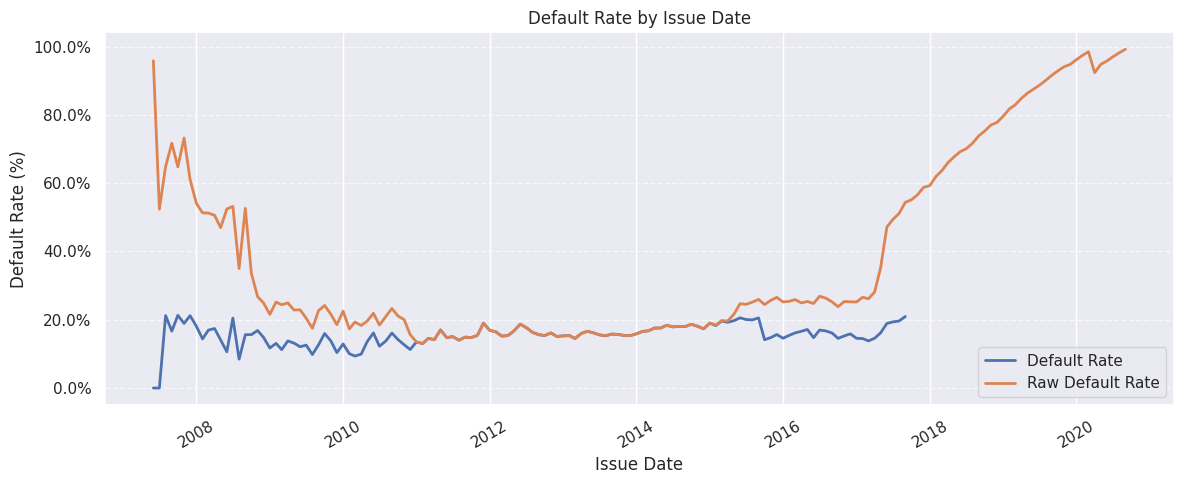

In [54]:
# Normal default rate: only for eligible (finalized) loans
plot_data = (
    data
    .groupby('loan_issue_date', as_index=False)['default_binary']
    .mean()
)
plot_data.columns = ['loan_issue_date', 'Default Rate']

# Combine both series for comparison plot
combined_plot_df = pd.merge(plot_data, plot_raw_data, on='loan_issue_date', how='outer').sort_values('loan_issue_date')

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=combined_plot_df, 
    x='loan_issue_date', 
    y='Default Rate', 
    label='Default Rate', 
    linewidth=2
)
sns.lineplot(
    data=combined_plot_df, 
    x='loan_issue_date', 
    y='Raw Default Rate', 
    label='Raw Default Rate', 
    linewidth=2
)

plt.title('Default Rate by Issue Date')
plt.xlabel('Issue Date')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The chart above illustrates the exact point made previously: without properly addressing censoring, the reported default rates can be misleading in certain periods. Continuing with the analysis without this treatment could result in conclusions that would be questionable in a real-world scenario.

Although this is not the ideal approach — since we lose a significant amount of data and there would be better ways to handle censoring if we had a more complete dataset with censoring information — it is still preferable to take this route rather than proceed without any correction for the biases that could otherwise result.

# Variable Roles and Data Availability

Since this is a credit granting dataset, it is critical to confirm that all explanatory variables are available ex-ante, at the moment of the loan request.

Here we should aim to:
- distinguish which variables are explanatory,
- and ensure no post-decision or post-outcome information is present.

But we already performed this step in the previous notebook: 00_data_acquisition.

Here, we will simply generate the list of variables that could be used as features for a model.

In [12]:
model_features = [
    # --- Applicant-Provided Information ---
    # Borrower Demographics & Employment
    "employment_title", 
    "employment_length_years",
    "home_ownership_status",
    "annual_income",
    "annual_income_joint",
    "state",
    "zip_code_first3",
    "application_type",
    # Loan Request Characteristics
    "loan_amount_requested",
    "loan_term_months",
    "loan_purpose",
    "loan_title",
    # Income Verification
    "income_verification_status",
    # --- Credit Bureau Information ---
    # Credit Scores
    "fico_score_low",
    "fico_score_high",
    # Debt & Affordability Ratios
    "debt_to_income_ratio",
    "debt_to_income_ratio_joint",
    # Credit History - Delinquency & Defaults
    "delinquencies_past_2years",
    "months_since_last_delinquency",
    "accounts_currently_delinquent",
    "delinquent_amount",
    "months_since_major_derogatory",
    "accounts_30days_past_due",
    "accounts_120days_past_due",
    "accounts_90plus_days_past_due_24m",
    "accounts_ever_120days_past_due",
    "public_records_count",
    "public_records_bankruptcies",
    "tax_liens_count",
    # Credit History - Credit Lines & Accounts
    "earliest_credit_line_date",
    "open_credit_lines",
    "total_credit_lines",
    "months_since_last_public_record",
    # Revolving Credit
    "revolving_balance",
    "revolving_utilization_rate",
    "revolving_trades_opened_12m",
    "revolving_trades_opened_24m",
    "revolving_accounts_count",
    "revolving_trades_with_balance",
    "open_revolving_trades",
    "active_revolving_trades",
    "months_since_oldest_revolving",
    "months_since_recent_revolving",
    "months_since_recent_revolving_delinquency",
    # Installment Accounts
    "active_installment_trades",
    "installment_accounts_opened_12m",
    "installment_accounts_opened_24m",
    "installment_accounts_count",
    "total_installment_balance",
    "installment_utilization",
    "months_since_recent_installment",
    "months_since_oldest_installment",
    "total_installment_credit_limit",
    # Bankcard Accounts
    "bankcard_accounts_count",
    "active_bankcard_accounts",
    "satisfactory_bankcard_accounts",
    "bankcard_utilization",
    "bankcard_open_to_buy",
    "max_balance_bankcard",
    "months_since_recent_bankcard",
    "months_since_recent_bankcard_delinquency",
    "percent_bankcard_over_75pct_limit",
    # Credit Inquiries & Recent Activity
    "inquiries_last_6months",
    "inquiries_last_12months",
    "finance_inquiries",
    "months_since_recent_inquiry",
    "open_trades_last_6months",
    "accounts_opened_past_12months",
    "accounts_opened_past_24months",
    # Account Balances & Limits
    "total_current_balance",
    "total_high_credit_limit",
    "total_balance_excluding_mortgage",
    "total_bankcard_limit",
    "average_current_balance",
    # Additional Account Metrics
    "satisfactory_accounts_count",
    "finance_trades_count",
    "months_since_recent_account",
    "mortgage_accounts_count",
    "percent_trades_never_delinquent",
    # Secondary Applicant (Joint Applications)
    "secondary_app_earliest_credit_line",
    "secondary_app_active_installment_trades"
]

# Data Quality Assessment

Before analyzing risk patterns, we assess the overall quality of the data.

Key questions explored in this section:
- Are there missing values? If so, how frequent are they?
- Are missing values concentrated in specific variables or segments?
- Are there duplicated records or obvious inconsistencies?
- Do numerical variables contain implausible values or extreme outliers?


In [18]:
len(list(model_features))

81

In [32]:
missing_counts = data[model_features].isna().sum()
missing_percent = data[model_features].isna().mean() * 100
missing_table = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_percent": missing_percent
    })
    .sort_values(by="missing_count", ascending=False)
)
missing_table.head(30)

,missing_count,missing_percent
secondary_app_active_installment_trades,1345907,99.358187
secondary_app_earliest_credit_line,1345907,99.358187
debt_to_income_ratio_joint,1338413,98.804962
annual_income_joint,1338410,98.804740
months_since_last_public_record,1126356,83.150389
months_since_recent_bankcard_delinquency,1028229,75.906411
months_since_major_derogatory,996198,73.541803
installment_utilization,893763,65.979798
months_since_recent_revolving_delinquency,893564,65.965107
months_since_recent_installment,835121,61.650700


In [17]:
null_percentage = missing_table["missing_percent"].values

deciles = list(range(0, 101, 10))
features_above_decile = []
for decile in deciles:
    count = (null_percentage > decile).sum()
    features_above_decile.append(count)

tabela_decis = pd.DataFrame({
    "decile (%)": deciles,
    "n_features_above_decile": features_above_decile
}).set_index("decile (%)")
tabela_decis.T


decile (%),0,10,20,30,40,50,60,70,80,90,100
n_features_above_decile,62,23,22,22,22,21,21,7,5,4,0


Of our initial 81 variables, more than 20 have over 60% missing values. For some of these, we can try to understand how the proportion of missing values changes over time.

['secondary_app_active_installment_trades', 'secondary_app_earliest_credit_line', 'debt_to_income_ratio_joint', 'annual_income_joint', 'months_since_last_public_record', 'months_since_recent_bankcard_delinquency', 'months_since_major_derogatory', 'installment_utilization', 'months_since_recent_revolving_delinquency', 'months_since_recent_installment', 'revolving_trades_opened_24m', 'active_installment_trades', 'revolving_trades_opened_12m', 'installment_accounts_opened_24m', 'inquiries_last_12months', 'finance_inquiries', 'total_installment_balance', 'max_balance_bankcard', 'finance_trades_count', 'open_trades_last_6months', 'installment_accounts_opened_12m', 'months_since_last_delinquency']


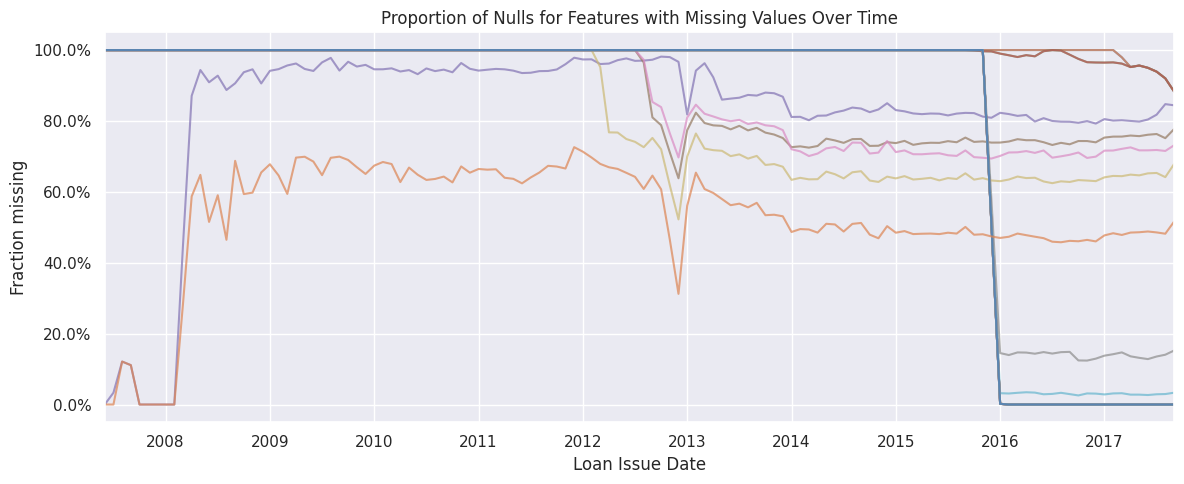

In [56]:
has_null_features = missing_table[missing_table["missing_percent"] > 30].index.tolist()
print(has_null_features)

nulls_over_time = data[has_null_features].isna().groupby(data["loan_issue_date"]).mean()

plt.figure(figsize=(12, 5))
nulls_over_time.plot(ax=plt.gca(), legend=False, alpha=0.7)
plt.title("Proportion of Nulls for Features with Missing Values Over Time")
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.ylabel("Fraction missing")
plt.xlabel("Loan Issue Date")
plt.tight_layout()
plt.show()

Many of the features with missing data have long periods where no values are present at all. Even when these features start to appear, they still tend to have a high proportion of missing values. In this case, it does not seem like missingness itself is informative. Some features do become completely filled after a certain point in time, but they only cover a very small portion of the dataset. For these reasons, I will proceed without including any of these features with high missingness.

In [37]:
model_features = [feature for feature in model_features if feature not in has_null_features]

In [38]:
data[model_features].duplicated().sum()

np.int64(0)

In [ ]:
numerical_columns = data[model_features].select_dtypes(include=["number"]).columns
data[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,1354601.0,75478.994147,85986.099954,0.0,45000.000,64000.00,90000.000,6.100000e+07
loan_amount_requested,1354601.0,13739.202097,8546.176584,500.0,7000.000,12000.00,19200.000,4.000000e+04
loan_term_months,1354601.0,39.807627,8.768414,36.0,36.000,36.00,36.000,6.000000e+01
fico_score_low,1354601.0,695.474442,31.378607,625.0,670.000,690.00,710.000,8.450000e+02
fico_score_high,1354601.0,699.474568,31.379207,629.0,674.000,694.00,714.000,8.500000e+02
debt_to_income_ratio,1354422.0,18.192026,9.807916,-1.0,11.830,17.61,24.010,9.990000e+02
delinquencies_past_2years,1354601.0,0.330849,0.898812,0.0,0.000,0.00,0.000,4.200000e+01
accounts_currently_delinquent,1354601.0,0.005526,0.080635,0.0,0.000,0.00,0.000,1.400000e+01
delinquent_amount,1354601.0,15.598629,825.424754,0.0,0.000,0.00,0.000,2.499250e+05
accounts_30days_past_due,1287074.0,0.003781,0.065421,0.0,0.000,0.00,0.000,4.000000e+00


The only inconsistency that stands out to me is the minimum value of debt_to_income_ratio being negative. Since there is only one row with this value, we will remove it and move forward.

In [50]:
display(data[['debt_to_income_ratio']].query('debt_to_income_ratio < 0'))
data = data.drop(data[data['debt_to_income_ratio'] < 0].index).reset_index(drop=True)

,debt_to_income_ratio
2320120,-1.0


# Target Variable Analysis

The target variable represents the **final status of the loan** (fully paid vs default).

In this section, we explore:
- the overall default rate,
- whether the dataset is highly imbalanced,
- and whether the observed default rate is consistent with expectations for unsecured personal loans.


We have already examined part of this earlier, but here I will present a clean chart and the expected average default rate. I will also try to analyze how default probability varies with the number of installments, for example.

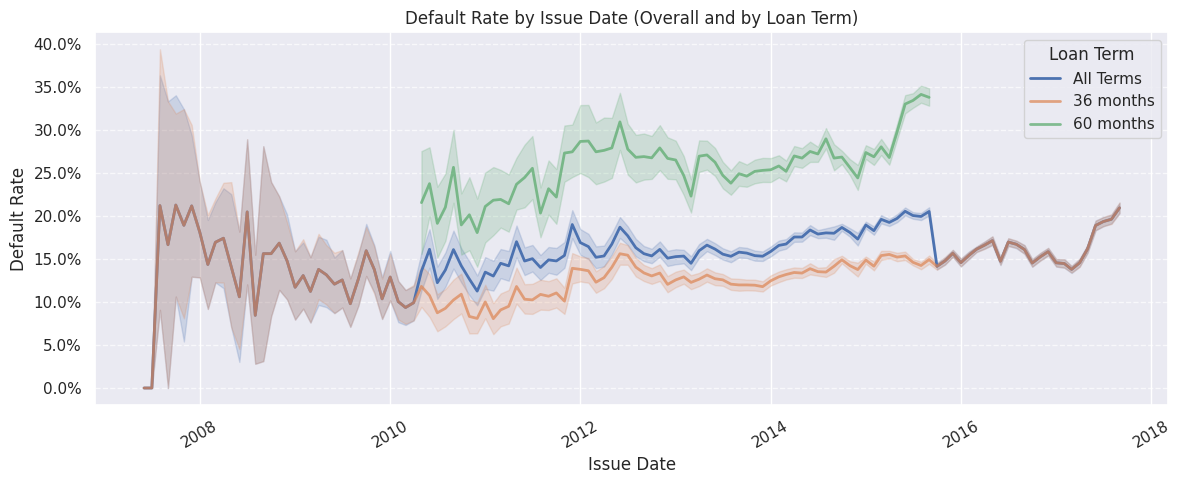

In [65]:
plt.figure(figsize=(12, 5))

# Plot overall default rate by issue date
sns.lineplot(
    data=data,
    x='loan_issue_date',
    y='default_binary',
    linewidth=2,
    label='All Terms'
)

# Plot for each loan_term_months separately
for term, df_term in data.groupby('loan_term_months'):
    sns.lineplot(
        data=df_term,
        x='loan_issue_date',
        y='default_binary',
        linewidth=2,
        label=f"{int(term)} months",
        alpha=0.7
    )

plt.title('Default Rate by Issue Date (Overall and by Loan Term)')
plt.xlabel('Issue Date')
plt.ylabel('Default Rate')
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
plt.legend(title='Loan Term')
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [73]:
data.groupby('loan_term_months').size()

loan_term_months
36    1139691
60     214909
dtype: int64

This explains the drop in the average risk in 2016: our censoring was excluding loans from this period with 60 monthly installments, which have a significantly higher risk than loans with 36 installments. Even so, it appears the censoring has not yet adequately addressed the most recent data.

To keep things simple, we will work only with loans that have 36 monthly installments. In the future, a policy could extend the results obtained for this product to the longer-term product as well. Furthermore, since we previously applied hypothesis-driven censoring, we will further trim the most recent data to ensure that the observed default rate is consistent with the rest of the dataset, assuming that this pattern is not the result of any specific company policy.

In [74]:
data.groupby('loan_issue_date')['default_binary'].mean().tail(10)

loan_issue_date
2016-12-01    0.158575
2017-01-01    0.145629
2017-02-01    0.144777
2017-03-01    0.137959
2017-04-01    0.145685
2017-05-01    0.161636
2017-06-01    0.189025
2017-07-01    0.193585
2017-08-01    0.196295
2017-09-01    0.209503
Name: default_binary, dtype: float64

In [75]:
data = data[data['loan_term_months'] == 36]
data = data[data['loan_issue_date'] < pd.to_datetime('2017-06-01')]

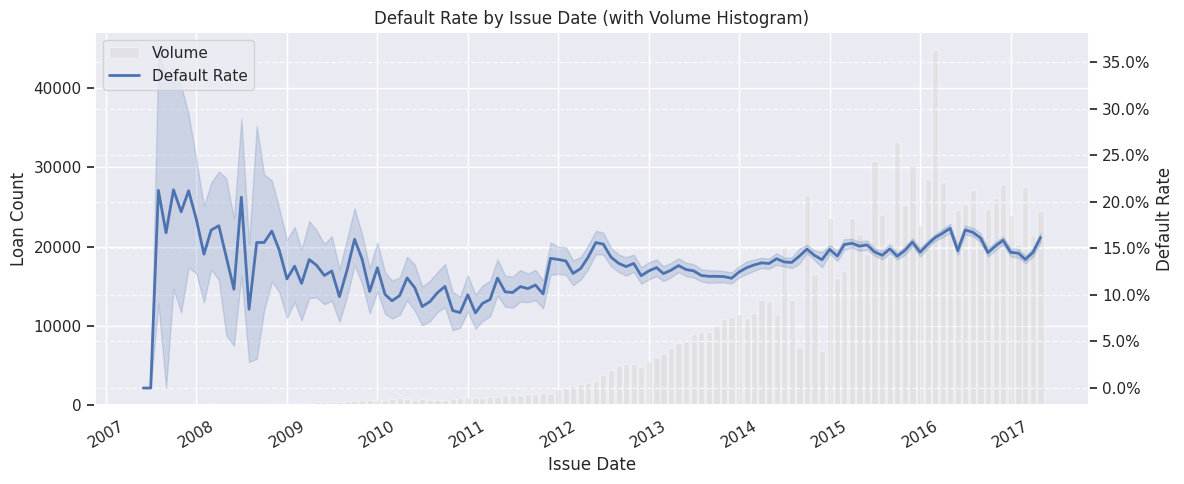

In [79]:
plt.figure(figsize=(12, 5))
ax1 = plt.gca()

counts_by_date = data.groupby('loan_issue_date').size()
ax1.bar(
    counts_by_date.index, 
    counts_by_date.values, 
    width=25,
    color='lightgrey', 
    alpha=0.4, 
    label='Volume',
    zorder=1
)

ax2 = ax1.twinx()
sns.lineplot(
    data=data,
    x='loan_issue_date',
    y='default_binary',
    linewidth=2,
    ax=ax2,
    color='C0',
    label='Default Rate',
    zorder=2
)

ax2.set_ylabel('Default Rate')
ax2.yaxis.set_major_formatter(lambda x, _: f"{x * 100:.1f}%")
ax1.set_ylabel('Loan Count')
ax1.set_xlabel('Issue Date')
plt.title('Default Rate by Issue Date (with Volume Histogram)')

for label in ax1.get_xticklabels():
    label.set_rotation(30)

ax2.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles1 + handles2, labels1 + labels2, loc='upper left', title=None)
plt.show()